# CNN

## Notebook's Environment

In [1]:
INSTALL_DEPS = False
if INSTALL_DEPS:
  %pip install matplotlib==3.8.3
  %pip installnumpy==1.26.4
  %pip installpandas==2.2.1
  %pip installpandas_market_calendars==4.4.0
  %pip installpytz==2024.1
  %pip installscipy==1.12.0
  %pip installta==0.11.0
  %pip installyfinance==0.2.37

!python --version

Python 3.11.8


## Cloud Environment Setup

In [2]:
import os
import sys
import warnings

warnings.filterwarnings("ignore")

IN_KAGGLE = IN_COLAB = False
try:
    # https://www.tensorflow.org/install/pip#windows-wsl2
    import google.colab
    from google.colab import drive

    drive.mount("/content/drive")
    DATA_PATH = "/content/drive/MyDrive/EDT dataset"
    MODEL_PATH = "/content/drive/MyDrive/models"
    IN_COLAB = True
    print("Colab!")
except:
    IN_COLAB = False
if "KAGGLE_KERNEL_RUN_TYPE" in os.environ and not IN_COLAB:
    print("Running in Kaggle...")
    for dirname, _, filenames in os.walk("/kaggle/input"):
        for filename in filenames:
            print(os.path.join(dirname, filename))
    MODEL_PATH = "./models"
    DATA_PATH = "/kaggle/input/"
    IN_KAGGLE = True
    print("Kaggle!")
elif not IN_COLAB:
    IN_KAGGLE = False
    MODEL_PATH = "./models"
    DATA_PATH = "./data/"
    print("running localhost!")

running localhost!


# Instruments

In [3]:
from constants import *

TARGET_FUT, INTERVAL

('ZC', '15m')

## Data Load

In [4]:
import pandas as pd
import numpy as np

filename = f"{DATA_PATH}{os.sep}futures_{INTERVAL}.csv"
print(filename)
futs_df = pd.read_csv(filename, index_col="Date", parse_dates=True)

print(futs_df.shape)
futs_df.head(2)

./data/\futures_15m.csv
(1938, 120)


,10Y_Open,10Y_High,10Y_Low,10Y_Close,10Y_Volume,10Y_Barcount,10Y_Average,10Y_Spread,2Y_Open,2Y_High,...,ZS_Average,ZS_Spread,ZW_Open,ZW_High,ZW_Low,ZW_Close,ZW_Volume,ZW_Barcount,ZW_Average,ZW_Spread
Date,,,,,,,,,,,,,,,,,,,,,
2023-12-29 15:30:00+00:00,3.883,3.883,3.86,3.860,95.0,48.0,3.8709,0.023,4.184,4.184,...,1308.375,5.0,630.25,632.00,626.25,629.50,3081.0,1133.0,628.7,5.75
2023-12-29 15:45:00+00:00,3.860,3.878,3.86,3.875,18.0,14.0,3.8722,0.018,4.184,4.184,...,1304.325,3.5,629.75,631.25,628.75,629.25,996.0,468.0,630.1,2.50


In [5]:
from quant_equations import get_ou, get_annualized_factor, calc_annualized_sharpe, deflated_sharpe_ratio

HALF_LIFE, HURST = get_ou(futs_df, f'{TARGET_FUT}_Close')

print("Half-Life:", HALF_LIFE)
print("Hurst:", HURST)

Half-Life: 135
Hurst: 0.5093444138309431


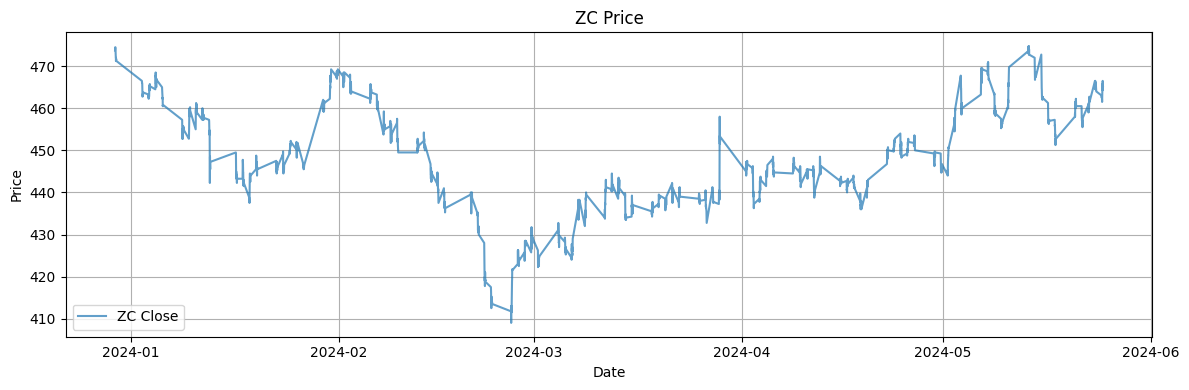

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.plot(futs_df[f'{TARGET_FUT}_Close'], label=f'{TARGET_FUT} Close', alpha=0.7)
plt.title(f'{TARGET_FUT} Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Prepare the Data

In [7]:
from signals import dynamic_support_resistance, kalman_backtest, signal_kf_bollinger_bands, signal_tsmom
from quant_equations import get_ou, modulate_std
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler

UNIVERSE_COLS = set()

def augment_ts(df, target_close, target_high, target_low, target_volume, interval):
    hl, h = get_ou(df, target_close)
    window = abs(hl)
    mod_std = modulate_std(h)

    mom_df = signal_tsmom(df[target_close], int(window*1.5), contra_lookback=window//2, std_threshold=mod_std)
    bb_df = signal_kf_bollinger_bands(df[target_close], df[target_volume], std_factor=mod_std)
    sr_df, _, _ = dynamic_support_resistance(df, target_close, target_high, target_low, window_size=hl)
    kf_df, _ = kalman_backtest(bb_df["%B"].bfill().ffill(), df[target_volume], df[target_close], period=interval)

    aug_ts_df = pd.concat([sr_df, kf_df, bb_df, mom_df], axis=1).bfill().ffill()
    aug_ts_df = aug_ts_df.loc[:, ~aug_ts_df.columns.duplicated()]
    return aug_ts_df

def process_exog(futures, futs_df, universe_cols=UNIVERSE_COLS):
    futs_exog_ts = []
    for f in tqdm(futures, desc="process_exog"):
        fut_df = futs_df.filter(regex=f"{f}_.*")

        universe_cols.update(fut_df.columns.tolist())

        train_df = fut_df
        futs_exog_ts.append(train_df)

    futs_exog_df = pd.concat(futs_exog_ts, axis=1)

    return futs_exog_df

def process_futures(futures, futs_df, futs_exog_df, train_size, interval, universe_cols=None):
    training_ts = []
    val_ts = []
    scalers = []
    for f in tqdm(futures, desc="process_futures"):
        fut_df = futs_df.filter(regex=f"{f}_.*")
        fut_df.columns = fut_df.columns.str.replace(f"{f}_", "", regex=False)

        if futs_exog_df is not None:
            fut_df = pd.concat([fut_df, futs_exog_df], axis=1)

        target_close = "Close"
        target_high = "High"
        target_low = "Low"
        target_volume = "Volume"

        if universe_cols is not None:
            # For utility, we have all futures columns.
            universe_cols.update(fut_df.columns.tolist())

        train_df = augment_ts(fut_df.iloc[:train_size], target_close, target_high, target_low, target_volume, interval)
        test_df = augment_ts(fut_df.iloc[train_size:], target_close, target_high, target_low, target_volume, interval)

        scaler = StandardScaler()
        train_df_scaled = scaler.fit_transform(train_df)
        test_df_scaled = scaler.transform(test_df)  # Only transform the test data, do not fit again

        train_df_scaled = pd.DataFrame(train_df_scaled, columns=train_df.columns)
        test_df_scaled = pd.DataFrame(test_df_scaled, columns=test_df.columns)

        training_ts.append(train_df_scaled.reset_index(drop=True))
        val_ts.append(test_df_scaled.reset_index(drop=True))
        scalers.append(scaler) # we use these later in the validation.

    return training_ts, val_ts, scalers

In [8]:
TEST_SPLIT = 0.6
TRAIN_SIZE = int(len(futs_df) * TEST_SPLIT)

futs_exog_df = process_exog(MARKET_FUTS, futs_df)
train_agri_ts, val_agri_ts, scalers = process_futures(AGRI_FUTS, futs_df, futs_exog_df, TRAIN_SIZE, INTERVAL)
# Stacking the lists of dataframes into single dataframes
train_ts_df = pd.concat([df.reset_index(drop=True) for df in train_agri_ts], axis=0, ignore_index=True).dropna()
test_ts_df = pd.concat([df.reset_index(drop=True) for df in val_agri_ts], axis=0, ignore_index=True).dropna()

test_ts_df.tail(5)

100%|██████████| 1046/1046 [00:00<00:00, 2356.77it/s]
kalman_backtest: 1046it [00:00, 6851.75it/s]
100%|██████████| 699/699 [00:01<00:00, 617.29it/s]
kalman_backtest: 699it [00:00, 2119.96it/s]
100%|██████████| 1046/1046 [00:01<00:00, 598.26it/s]
kalman_backtest: 1046it [00:00, 3710.35it/s]
100%|██████████| 699/699 [00:00<00:00, 2319.71it/s]
kalman_backtest: 699it [00:00, 7748.45it/s]
100%|██████████| 1046/1046 [00:00<00:00, 2456.40it/s]
kalman_backtest: 1046it [00:00, 7590.91it/s]
100%|██████████| 699/699 [00:00<00:00, 2443.28it/s]
kalman_backtest: 699it [00:00, 7039.77it/s]
100%|██████████| 1046/1046 [00:00<00:00, 2314.45it/s]
kalman_backtest: 1046it [00:00, 6630.78it/s]
100%|██████████| 699/699 [00:00<00:00, 2362.04it/s]
kalman_backtest: 699it [00:00, 7365.73it/s]
100%|██████████| 1046/1046 [00:00<00:00, 2322.98it/s]
kalman_backtest: 1046it [00:00, 5814.88it/s]
100%|██████████| 699/699 [00:00<00:00, 2366.96it/s]
kalman_backtest: 699it [00:00, 6709.69it/s]
100%|██████████| 1046/1046 

,Open,High,Low,Close,Volume,Barcount,Average,Spread,ES_Open,ES_High,...,Unreal_Ret,cRets,Drawdown,MA,SD,U,L,%B,TSMOM,CONTRA
6979,1.071483,1.051774,1.061019,1.056136,-0.473323,-0.504804,1.055632,-0.288584,1.693305,1.693437,...,0.101619,3.064151,1.319964,1.099167,-0.896972,1.090869,1.107252,-0.600696,2.990794,-0.186356
6980,1.050399,1.024924,1.026492,1.000500,0.237872,0.103630,1.015916,-0.044704,1.710449,1.712028,...,0.101619,3.064151,1.319964,1.092300,-0.461574,1.090286,1.094101,-1.149440,2.990794,-0.186356
6981,1.002482,1.013417,1.020738,0.998581,-0.297775,-0.430604,1.018218,-0.227614,1.714735,1.697727,...,0.101619,3.064151,1.319964,1.081812,-0.350532,1.081402,1.082010,-1.039648,2.990794,-0.186356
6982,0.996732,1.013417,1.024574,1.006255,0.922060,0.637864,1.019177,-0.349554,1.701877,1.704877,...,0.101619,3.064151,1.319964,1.077896,0.123959,1.084335,1.071247,-0.874270,2.990794,-0.186356
6983,1.002482,0.999992,1.026492,1.025440,-0.356291,-0.630942,1.010735,-0.837314,1.710449,1.724898,...,0.101619,3.064151,1.319964,1.071719,0.038052,1.076918,1.066309,-0.598443,2.990794,-0.186356


In [9]:
PREDICTION_HORIZON = 1
WINDOW  = HALF_LIFE + 2

def prepare_windows(
    data_df,
    label_df,
    window_size=WINDOW,
    horizon=PREDICTION_HORIZON,
):
    assert len(data_df) > 1
    X, y = [], []
    for i in tqdm(
        range(len(data_df) - window_size - horizon + 1), desc=f"Encoding Widows of {window_size} with {horizon} horizon."
    ):
        input_window = data_df.iloc[i : i + window_size].values
        X.append(input_window)
        if label_df is not None:
            target_window = label_df.iloc[i + window_size : i + window_size + horizon].values
            y.append(target_window)

    return np.array(X),  np.array(y)

META_LABEL = "mr_label"

def aug_metalabel_mr(df, metalabel = META_LABEL):
    df = df.copy()
    df[metalabel] = 0
    position = 0
    start_index = None

    for i, row in tqdm(df.iterrows(), desc="Posthoc Metalabeling"):
        if row['Closed'] != 0:
            # Position closed, work backwards
            ret = row['Ret']
            metalabel = (ret > 0).astype(int)
            if start_index is not None:
                df.loc[start_index:row.name, META_LABEL] = metalabel

            position = 0
            start_index = None

        if row['Position'] != 0 and position == 0:
            # New position opened
            position = row['Position']
            start_index = row.name

    return df

train_ts_df = aug_metalabel_mr(train_ts_df)
test_ts_df = aug_metalabel_mr(test_ts_df)

X, y = prepare_windows(train_ts_df.drop(columns=[META_LABEL]), train_ts_df[META_LABEL])
X_t, y_t = prepare_windows(test_ts_df.drop(columns=[META_LABEL]), test_ts_df[META_LABEL])
X_t[0], y_t[0]

Posthoc Metalabeling: 10458it [00:01, 7589.10it/s]
Posthoc Metalabeling: 6984it [00:00, 8384.37it/s]
Encoding Widows of 137 with 1 horizon.: 100%|██████████| 6847/6847 [00:00<00:00, 54299.59it/s]


(array([[-0.37531591, -0.37771295, -0.37685161, ..., -0.7872725 ,
          0.0499716 , -0.54486237],
        [-0.41083901, -0.44922454, -0.43014591, ..., -0.64568484,
          0.0499716 , -0.54486237],
        [-0.44636211, -0.35983505, -0.41238115, ...,  0.44490068,
          0.0499716 , -0.54486237],
        ...,
        [ 0.01543818,  0.03347875, -0.05708576, ..., -0.76736068,
          0.0499716 , -0.54486237],
        [-0.07336957, -0.09166655, -0.11038006, ..., -1.17469196,
          0.0499716 , -0.54486237],
        [-0.14441577, -0.09166655, -0.1459096 , ..., -0.56540556,
          0.0499716 , -0.54486237]]),
 array([0], dtype=int64))

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import (
    SpatialDropout1D,
    Dense,
    Conv1D,
    Layer,
    Add,
    Input,
    Concatenate,
    Flatten,
)
from tensorflow.keras import Model
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

MODEL_NAME = "WAVENET"
EPOCHS = 300
PATIENCE_EPOCHS = 15
BATCH_SIZE = 124
MIN_FILTER = 12
MIN_DENSE = 256
FILTERS = [MIN_FILTER, MIN_FILTER*2]
HIDDEN_DENSE = [MIN_DENSE]
BIAS = True
DROPRATE = 0.25
POOL_SIZE = 8
KERNEL_SIZE = 2
DILATION_RATE = 1
REG_WEIGHTS = 0.005


tf.keras.saving.get_custom_objects().clear()

@tf.keras.saving.register_keras_serializable()
class ConvBlock(Layer):
    """
    CNN Residual Block that uses zero-padding to maintain `steps` value of the ouput equal to the one in the input.
    Residual Block is obtained by stacking togeather (2x) the following:
        - 1D Dilated Convolution
        - ReLu
        - Spatial Dropout
    And adding the input after trasnforming it with a 1x1 Conv
    """

    def __init__(
        self,
        filters=1,
        kernel_size=2,
        dilation_rate=1,
        kernel_initializer="glorot_normal",
        bias_initializer="glorot_normal",
        kernel_regularizer=None,
        bias_regularizer=None,
        use_bias=False,
        dropout_rate=0.0,
        layer_id=None,
        **kwargs,
    ):
        super(ConvBlock, self).__init__(**kwargs)
        assert dilation_rate is not None and dilation_rate > 0 and filters > 0 and kernel_size > 0

        self.filters = filters
        self.kernel_size = kernel_size
        self.dilation_rate = dilation_rate
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer
        self.kernel_regularizer = kernel_regularizer
        self.bias_regularizer = bias_regularizer
        self.use_bias = use_bias
        self.dropout_rate = dropout_rate
        self.layer_id = str(layer_id)

    def get_config(self):
        config = super(ConvBlock, self).get_config()
        config.update({
            'filters': self.filters,
            'kernel_size': self.kernel_size,
            'dilation_rate': self.dilation_rate,
            'kernel_initializer': self.kernel_initializer,
            'bias_initializer': self.bias_initializer,
            'kernel_regularizer': self.kernel_regularizer,
            'bias_regularizer': self.bias_regularizer,
            'use_bias': self.use_bias,
            'dropout_rate': self.dropout_rate,
        })
        return config

    def build(self, inputs):
        self.conv1 = Conv1D(
            filters=self.filters,
            kernel_size=self.kernel_size,
            use_bias=self.use_bias,
            bias_initializer=self.bias_initializer,
            bias_regularizer=self.bias_regularizer,
            kernel_initializer=self.kernel_initializer,
            kernel_regularizer=self.kernel_regularizer,
            padding="causal",
            dilation_rate=self.dilation_rate,
            activation="relu",
            name=f"Conv1D_1_{self.layer_id}"
        )
        # Spatial dropout is specific to convolutions by dropping an entire timewindow,
        # not to rely too heavily on specific features detected by the kernels.
        self.dropout1 = SpatialDropout1D(
            self.dropout_rate, trainable=True, name=f"SpatialDropout1D_1_{self.layer_id}"
        )
        # Capture a higher order feature set from the previous convolution
        self.conv2 = Conv1D(
            filters=self.filters,
            kernel_size=self.kernel_size,
            use_bias=self.use_bias,
            bias_initializer=self.bias_initializer,
            bias_regularizer=self.bias_regularizer,
            kernel_initializer=self.kernel_initializer,
            kernel_regularizer=self.kernel_regularizer,
            padding="causal",
            dilation_rate=self.dilation_rate,
            activation="relu",
            name=f"Conv1D_2_{self.layer_id}"
        )
        self.dropout2 = SpatialDropout1D(
            self.dropout_rate, trainable=True, name=f"SpatialDropout1D_2_{self.layer_id}"
        )
        # The skip connection is an addition of the input to the block with the output of the second dropout layer.
        # Solves vanishing gradient, carries info from earlier layers to later layers, allowing gradients to flow across this alternative path.
        # Does not learn direct mappings, but differences (residuals) while keeping temporal context.
        # Note how it keeps dims intact with kernel 1.
        self.skip_out = Conv1D(
            filters=self.filters,
            kernel_size=1,
            activation="linear",
            padding="same",
            name=f"Conv1D_skipconnection_{self.layer_id}",
        )
        # This is the elementwise add for the residual connection and Conv1d 2's output
        self.residual_out = Add(name=f"residual_Add_{self.layer_id}")

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = self.dropout2(x)

        # Residual output by adding the inputs back
        skip_out_x = self.skip_out(inputs)
        x = self.residual_out([x, skip_out_x])
        return x, skip_out_x


def CNN(
    input_shape,
    dense_units=None,
    output_horizon=PREDICTION_HORIZON,
    filters=[MIN_FILTER],
    kernel_size=KERNEL_SIZE,
    dilation_rate=DILATION_RATE,
    kernel_regularizer=None,
    bias_regularizer=None,
    use_bias=False,
    dropout_rate=DROPRATE,
):
    """
    Tensorflow CNN Model builder.
    see: https://www.tensorflow.org/api_docs/python/tf/keras/Model
    see: https://www.tensorflow.org/guide/keras/making_new_layers_and_models_via_subclassing#the_model_class
    see: https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/L2
    """
    main_input = Input(shape=input_shape, name="main_input")
    x = main_input
    skip_connections = []
    for i, filter in enumerate(filters):
        x, x_skip = ConvBlock(
            filters=filter,
            kernel_size=kernel_size,
            dilation_rate=dilation_rate ** (i + 1),
            kernel_regularizer=kernel_regularizer,
            bias_regularizer=bias_regularizer,
            use_bias=use_bias,
            dropout_rate=dropout_rate,
            layer_id=i,
        )(x)
        skip_connections.append(x_skip)
    if skip_connections:
        skip_connections.append(x)
        aggregated = Concatenate(axis=-1, name=f"Final_Residuals")(skip_connections)
        aggregated = Conv1D(filters[-1], kernel_size=1, activation="linear", padding='same')(aggregated)
    if dense_units:
        # Dense networks for deep learning ifrequired.
        x = Flatten()(x)
        # First layer
        x = Dense(dense_units[0], input_shape=input_shape, activation="tanh", name=f"Dense_0")(x)
        for i, units  in enumerate(dense_units, start=1):
            x = Dense(units , activation="tanh", name=f"Dense__{i}")(x)
        # Last layer - Logits output
        x = Dense(output_horizon, activation=None, name=f"Dense_Classifier")(x)
    else:
        x = Conv1D(filters=output_horizon, kernel_size=1, padding="causal", activation=None, name=f"Conv_Classifier")(x)

    model = Model(
        inputs=[main_input],
        outputs=x,
        name=MODEL_NAME,
    )
    return model

In [11]:
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.losses import BinaryCrossentropy, BinaryFocalCrossentropy
from tensorflow.keras.metrics import AUC, BinaryAccuracy, Recall, Precision

MODEL_DIR = f"models/{MODEL_NAME}"
IMAGES_DIR = f"images/{MODEL_NAME}/images"
LOG_BASEPATH = f"logs/{MODEL_NAME}/tb"

weights = compute_class_weight(class_weight="balanced", classes=np.unique(y.flatten()), y=y.flatten().flatten())
CLASS_WEIGHTS = {i: weights[i] for i in range(len(weights))}
print(f"wieghts: {CLASS_WEIGHTS}")

LEARN_RATE = 0.01
ERROR_ALPHA = 0.55 # 0.5 > gives more weight to positive class errors
ERROR_GAMMA = 0.2 # loss contribution from easy examples. 0 > focus on hard examples.
CLASS_WEIGHTS = None
TARGET_METRIC = "auc"
LOSS = BinaryFocalCrossentropy(apply_class_balancing=True, from_logits=True, alpha=ERROR_ALPHA, gamma=ERROR_GAMMA, name='fbce')
METRICS = [BinaryAccuracy(name='ba'), AUC(name=TARGET_METRIC, from_logits=True, label_weights=CLASS_WEIGHTS)]

def build_tcn(
    input_shape,
    X, y,
    Xt=None, yt=None,
    output_horizon= PREDICTION_HORIZON,
    filters= FILTERS,
    kernel_size= KERNEL_SIZE,
    dilation_rate= DILATION_RATE,
    kernel_regularizer=L1L2(l1= REG_WEIGHTS, l2=REG_WEIGHTS//10),
    bias_regularizer=L1L2(l1= REG_WEIGHTS, l2=REG_WEIGHTS//10),
    dropout_rate=DROPRATE,
    dense_units=HIDDEN_DENSE,
    lr=LEARN_RATE,
    patience=PATIENCE_EPOCHS,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    use_bias=BIAS,
    loss=LOSS,
    class_weights=CLASS_WEIGHTS,
):
    assert len(X) > 1 and len(y) > 1 and input_shape is not None, f"{len(X)} > 1 and {len(y)} > 1 and {input_shape} is not None"

    model = CNN(
        input_shape=input_shape,
        dense_units=dense_units,
        output_horizon=output_horizon,
        filters=filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        kernel_regularizer=kernel_regularizer,
        bias_regularizer=bias_regularizer,
        use_bias=use_bias,
        dropout_rate=dropout_rate,
    )

    model.compile(loss=loss, optimizer=Adam(learning_rate=lr), metrics=METRICS)
    callbacks = [EarlyStopping(
                    patience=patience,
                    monitor=f"val_{TARGET_METRIC}",
                    restore_best_weights=True,
                ),
                ReduceLROnPlateau(monitor=f"val_{TARGET_METRIC}",
                                factor=0.5,
                                patience=patience // 3,
                                verbose=1,
                                min_lr=1e-6
                )]

    callbacks.append(TensorBoard(log_dir=LOG_BASEPATH,
                                histogram_freq=1,
                                write_graph=True,
                                write_images=True,
                                update_freq='epoch',
                                profile_batch=2,
                                embeddings_freq=1))

    assert len(Xt) > 1 and len(yt) > 1
    history = model.fit(
        X,
        y,
        validation_data=(Xt, yt),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=1,
    )

    return model, history

input_shape = (
    WINDOW,
    1 if len(X.shape) < 3 else X.shape[2],
)

model, history = build_tcn(input_shape, X=X, y=y, Xt=X_t, yt=y_t)
model.save(MODEL_PATH)

model.summary()

wieghts: {0: 0.6526495510307323, 1: 2.137738193869097}

Epoch 1/300

84/84 [==============================] - 4s 27ms/step - loss: 0.7960 - ba: 0.7682 - auc: 0.6616 - val_loss: 0.3330 - val_ba: 0.7570 - val_auc: 0.6355 - lr: 0.0100
Epoch 2/300
84/84 [==============================] - 2s 18ms/step - loss: 0.1916 - ba: 0.8382 - auc: 0.8675 - val_loss: 0.2968 - val_ba: 0.6753 - val_auc: 0.7174 - lr: 0.0100
Epoch 3/300
84/84 [==============================] - 2s 21ms/step - loss: 0.1472 - ba: 0.8817 - auc: 0.9245 - val_loss: 0.3745 - val_ba: 0.6623 - val_auc: 0.7003 - lr: 0.0100
Epoch 4/300
84/84 [==============================] - 2s 20ms/step - loss: 0.1476 - ba: 0.8781 - auc: 0.9245 - val_loss: 0.3882 - val_ba: 0.7652 - val_auc: 0.7006 - lr: 0.0100
Epoch 5/300
84/84 [==============================] - 2s 19ms/step - loss: 0.1601 - ba: 0.8550 - auc: 0.9110 - val_loss: 0.4402 - val_ba: 0.6026 - val_auc: 0.5926 - lr: 0.0100
Epoch 6/300
84/84 [==============================] - 2s 19ms/step - 

INFO:tensorflow:Assets written to: ./models\assets


Model: "WAVENET"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 main_input (InputLayer)     [(None, 137, 89)]         0         
                                                                 
 conv_block (ConvBlock)      ((None, 137, 12),         3528      
                              (None, 137, 12))                   
                                                                 
 conv_block_1 (ConvBlock)    ((None, 137, 24),         2088      
                              (None, 137, 24))                   
                                                                 
 flatten (Flatten)           (None, 3288)              0         
                                                                 
 Dense_0 (Dense)             (None, 256)               841984    
                                                                 
 Dense__1 (Dense)            (None, 256)               6579

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, fbeta_score, roc_auc_score

ypred_raw = model.predict([X_t])
pred = (ypred_raw > 0.5).astype(int)
metrics = {}

metrics = {
    "Accuracy": accuracy_score(y_t.flatten(), pred.flatten()),
    "Precision": precision_score(y_t.flatten(), pred.flatten()),
    "Recall": recall_score(y_t.flatten(), pred.flatten()),
    "F1b Score": fbeta_score(y_t.flatten(), pred.flatten(), average="weighted", beta=0.5),
    "ROC AUC": roc_auc_score(y_t.flatten(), ypred_raw.flatten(), average='weighted')  # Using raw probabilities
}

metrics_unseen_df = pd.DataFrame.from_dict(metrics, orient='index')
metrics_unseen_df

214/214 [==============================] - 1s 3ms/step


,0
Accuracy,0.761501
Precision,0.494306
Recall,0.867583
F1b Score,0.811379
ROC AUC,0.834093


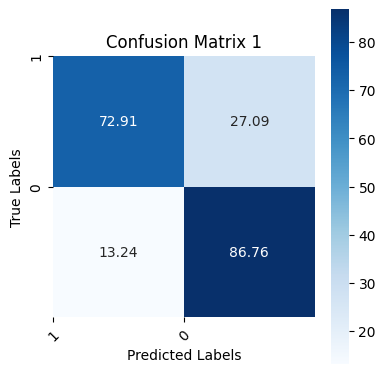

In [13]:
from tensorflow.math import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(cm, labels, cm2=None, labels2=None):
        plt.figure(figsize=(8 if cm2 is not None else 4, 4))
        if cm2 is not None:
            plt.subplot(1, 2, 1)
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Accent)

        df_cm = pd.DataFrame((cm / np.sum(cm, axis=1)[:, None])*100, index=[i for i in labels], columns=[i for i in labels])
        cm_plot1 = sns.heatmap(df_cm, annot=True,  fmt=".2f", cmap='Blues', xticklabels=labels, yticklabels=labels).get_figure()
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix 1')
        tick_marks = np.arange(len(labels))
        plt.xticks(tick_marks, labels, rotation=45)
        plt.yticks(tick_marks, labels)

        cm_plot2=None
        if cm2 is not None:
            plt.subplot(1, 2, 2)
            df_cm = pd.DataFrame((cm2 / np.sum(cm2, axis=1)[:, None])*100, index=[i for i in labels2], columns=[i for i in labels2])
            cm_plot12 = sns.heatmap(df_cm, annot=True,  fmt=".2f", cmap='Reds', xticklabels=labels, yticklabels=labels).get_figure()
            plt.xlabel('Predicted Labels')
            plt.title('Confusion Matrix 2')
        plt.tight_layout()

        return cm_plot1, cm_plot2


cm = confusion_matrix(y_t.flatten(), pred)
figure, _ = plot_confusion_matrix(cm, labels=[1,0])

# CV

In [14]:
from sklearn.model_selection import TimeSeriesSplit
import json
import os

CV_MODEL = True
CV_SPLITS = 3

def train_cv_model(X, y, input_shape, n_splits=5, perturb=True, window=WINDOW, horizon=PREDICTION_HORIZON):
    def _perturb_gaussiannoise(X, noise_level=0.1):
        sigma = noise_level * np.std(X)
        noise = np.random.normal(0, sigma, X.shape)
        return X + noise

    if perturb:
        X = _perturb_gaussiannoise(X)

    results = []
    tscv = TimeSeriesSplit(n_splits=n_splits)
    global metrics_col
    metrics_col = None

    for train_index, test_index in tqdm(tscv.split(X), desc=f"CV Testing for n_splits: {n_splits}"):
        X_train = X.iloc[train_index]
        y_train = y.iloc[train_index]
        X_test = X.iloc[test_index]
        y_test = y.iloc[test_index]

        X_train_windows, y_train_windows = prepare_windows(X_train, y_train, window_size=window, horizon=horizon)
        X_test_windows, y_test_windows = prepare_windows(X_test, y_test, window_size=window, horizon=horizon)

        try:
            cv_model, _ = build_tcn(input_shape, X=X_train_windows, y=y_train_windows, Xt=X_test_windows, yt=y_test_windows)

            result = cv_model.evaluate([X_test_windows], y_test_windows, verbose=0)
            results.append(result)

            if metrics_col is None:
                metrics_col = cv_model.metrics
        except Exception as e:
            print(f"CV error on fold with exception: {e}")

    if metrics_col is None:
        raise ValueError("No successful model training; metrics_col is None")

    metrics_names = [metric.name for metric in metrics_col]
    results_df = pd.DataFrame(results, columns=metrics_names)

    return results_df

results_df = train_cv_model(train_ts_df.drop(columns=[META_LABEL]), train_ts_df[META_LABEL], input_shape)
results_df

Encoding Widows of 137 with 1 horizon.: 100%|██████████| 1606/1606 [00:00<00:00, 41567.23it/s]


Epoch 1/300
13/13 [==============================] - 3s 79ms/step - loss: 2.2172 - ba: 0.5770 - auc: 0.6338 - val_loss: 1.8994 - val_ba: 0.4184 - val_auc: 0.2166 - lr: 0.0100
Epoch 2/300
13/13 [==============================] - 1s 46ms/step - loss: 0.9964 - ba: 0.7435 - auc: 0.8486 - val_loss: 1.2104 - val_ba: 0.5660 - val_auc: 0.1963 - lr: 0.0100
Epoch 3/300
13/13 [==============================] - 1s 46ms/step - loss: 0.4985 - ba: 0.8960 - auc: 0.9610 - val_loss: 0.9319 - val_ba: 0.6887 - val_auc: 0.2202 - lr: 0.0100
Epoch 4/300
13/13 [==============================] - 1s 47ms/step - loss: 0.2332 - ba: 0.9844 - auc: 0.9864 - val_loss: 1.2690 - val_ba: 0.5430 - val_auc: 0.2778 - lr: 0.0100
Epoch 5/300
13/13 [==============================] - 1s 46ms/step - loss: 0.1324 - ba: 0.9888 - auc: 0.9874 - val_loss: 1.2400 - val_ba: 0.5324 - val_auc: 0.3187 - lr: 0.0100
Epoch 6/300
13/13 [==============================] - 1s 48ms/step - loss: 0.0847 - ba: 0.9888 - auc: 0.9901 - val_loss: 1.203

Encoding Widows of 137 with 1 horizon.: 100%|██████████| 1606/1606 [00:00<00:00, 53257.42it/s]


Epoch 1/300
28/28 [==============================] - 2s 38ms/step - loss: 1.6505 - ba: 0.5897 - auc: 0.4877 - val_loss: 0.7967 - val_ba: 0.4315 - val_auc: 0.5485 - lr: 0.0100
Epoch 2/300
28/28 [==============================] - 1s 25ms/step - loss: 0.5068 - ba: 0.6706 - auc: 0.6145 - val_loss: 0.4154 - val_ba: 0.5940 - val_auc: 0.4148 - lr: 0.0100
Epoch 3/300
28/28 [==============================] - 1s 25ms/step - loss: 0.3712 - ba: 0.6357 - auc: 0.5881 - val_loss: 0.3118 - val_ba: 0.9078 - val_auc: 0.5451 - lr: 0.0100
Epoch 4/300
28/28 [==============================] - 1s 25ms/step - loss: 0.2687 - ba: 0.7787 - auc: 0.7419 - val_loss: 0.2862 - val_ba: 0.8755 - val_auc: 0.4542 - lr: 0.0100
Epoch 5/300
28/28 [==============================] - 1s 25ms/step - loss: 0.2183 - ba: 0.8173 - auc: 0.8150 - val_loss: 0.3877 - val_ba: 0.7715 - val_auc: 0.5628 - lr: 0.0100
Epoch 6/300
28/28 [==============================] - 1s 26ms/step - loss: 0.2086 - ba: 0.8017 - auc: 0.8606 - val_loss: 0.365

Encoding Widows of 137 with 1 horizon.: 100%|██████████| 1606/1606 [00:00<00:00, 24702.42it/s]


Epoch 1/300
42/42 [==============================] - 3s 30ms/step - loss: 1.2387 - ba: 0.7416 - auc: 0.5088 - val_loss: 0.3928 - val_ba: 0.9309 - val_auc: 0.5439 - lr: 0.0100
Epoch 2/300
42/42 [==============================] - 1s 21ms/step - loss: 0.2264 - ba: 0.8743 - auc: 0.9258 - val_loss: 0.3348 - val_ba: 0.7522 - val_auc: 0.4689 - lr: 0.0100
Epoch 3/300
42/42 [==============================] - 1s 21ms/step - loss: 0.0883 - ba: 0.9611 - auc: 0.9743 - val_loss: 0.2763 - val_ba: 0.7721 - val_auc: 0.4845 - lr: 0.0100
Epoch 4/300
42/42 [==============================] - 1s 21ms/step - loss: 0.0646 - ba: 0.9778 - auc: 0.9771 - val_loss: 0.4154 - val_ba: 0.7453 - val_auc: 0.5032 - lr: 0.0100
Epoch 5/300
42/42 [==============================] - 1s 21ms/step - loss: 0.0537 - ba: 0.9857 - auc: 0.9792 - val_loss: 0.5990 - val_ba: 0.6594 - val_auc: 0.5438 - lr: 0.0100
Epoch 6/300
42/42 [==============================] - 1s 21ms/step - loss: 0.0619 - ba: 0.9823 - auc: 0.9726 - val_loss: 0.678

Encoding Widows of 137 with 1 horizon.: 100%|██████████| 1606/1606 [00:00<00:00, 50451.27it/s]


Epoch 1/300
56/56 [==============================] - 3s 24ms/step - loss: 1.0024 - ba: 0.8292 - auc: 0.6065 - val_loss: 0.3298 - val_ba: 0.6326 - val_auc: 0.8944 - lr: 0.0100
Epoch 2/300
56/56 [==============================] - 1s 18ms/step - loss: 0.1519 - ba: 0.9317 - auc: 0.9401 - val_loss: 0.1428 - val_ba: 0.8748 - val_auc: 0.9690 - lr: 0.0100
Epoch 3/300
56/56 [==============================] - 1s 17ms/step - loss: 0.0663 - ba: 0.9800 - auc: 0.9673 - val_loss: 0.1344 - val_ba: 0.8705 - val_auc: 0.9564 - lr: 0.0100
Epoch 4/300
56/56 [==============================] - 1s 18ms/step - loss: 0.0552 - ba: 0.9858 - auc: 0.9700 - val_loss: 0.1414 - val_ba: 0.9377 - val_auc: 0.9322 - lr: 0.0100
Epoch 5/300
56/56 [==============================] - 1s 21ms/step - loss: 0.0591 - ba: 0.9822 - auc: 0.9709 - val_loss: 0.0982 - val_ba: 0.9197 - val_auc: 0.9784 - lr: 0.0100
Epoch 6/300
52/56 [==========================>...] - ETA: 0s - loss: 0.0565 - ba: 0.9836 - auc: 0.9755
Epoch 6: ReduceLROnPla

Encoding Widows of 137 with 1 horizon.: 100%|██████████| 1606/1606 [00:00<00:00, 38418.62it/s]


Epoch 1/300
70/70 [==============================] - 3s 22ms/step - loss: 0.8156 - ba: 0.8136 - auc: 0.7844 - val_loss: 0.4639 - val_ba: 0.7478 - val_auc: 0.6383 - lr: 0.0100
Epoch 2/300
70/70 [==============================] - 1s 16ms/step - loss: 0.1069 - ba: 0.9545 - auc: 0.9651 - val_loss: 0.3681 - val_ba: 0.7123 - val_auc: 0.8641 - lr: 0.0100
Epoch 3/300
70/70 [==============================] - 1s 17ms/step - loss: 0.0605 - ba: 0.9820 - auc: 0.9771 - val_loss: 0.3649 - val_ba: 0.6700 - val_auc: 0.7547 - lr: 0.0100
Epoch 4/300
70/70 [==============================] - 1s 17ms/step - loss: 0.0583 - ba: 0.9836 - auc: 0.9777 - val_loss: 0.6142 - val_ba: 0.6663 - val_auc: 0.6660 - lr: 0.0100
Epoch 5/300
70/70 [==============================] - 1s 17ms/step - loss: 0.0755 - ba: 0.9676 - auc: 0.9726 - val_loss: 0.7541 - val_ba: 0.4932 - val_auc: 0.5070 - lr: 0.0100
Epoch 6/300
70/70 [==============================] - 1s 17ms/step - loss: 0.0645 - ba: 0.9761 - auc: 0.9791 - val_loss: 0.604

CV Testing for n_splits: 5: 5it [01:42, 20.52s/it]


,loss,ba,auc
0,1.110238,0.525529,0.373516
1,0.387672,0.771482,0.562816
2,0.392767,0.930884,0.543909
3,0.065146,0.953923,0.992818
4,0.368103,0.712329,0.864083
